# Импорты

In [769]:
import warnings
import random

import pandas as pd
import numpy as np
from scipy.stats import ttest_rel, ttest_ind, binned_statistic
from sklearn import metrics, svm
from sklearn.metrics import roc_curve, roc_auc_score, plot_confusion_matrix
from sklearn.linear_model import LogisticRegression as LR
from sklearn.preprocessing import scale
from sklearn.calibration import calibration_curve
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from category_encoders.target_encoder import TargetEncoder
from matplotlib import pyplot as plt
import itertools
import matplotlib.ticker as ticker
from plot_metric import functions
import seaborn as sns

# Опции

In [2]:
pd.set_option('max_columns', 50)
plt.style.use('ggplot')
warnings.filterwarnings('ignore')

# Развед анализ

In [701]:
df_url = '~/Desktop/testing/dodo/data/data.csv'
df = pd.read_csv(df_url, engine='python')

print(df.shape)
df.head(10)

(20468, 29)


,age,annualincome,calldroprate,callfailurerate,callingnum,customerid,customersuspended,education,gender,homeowner,maritalstatus,monthlybilledamount,noadditionallines,numberofcomplaints,numberofmonthunpaid,numdayscontractequipmentplanexpiring,occupation,penaltytoswitch,state,totalminsusedinlastmonth,unpaidbalance,usesinternetservice,usesvoiceservice,percentagecalloutsidenetwork,totalcallduration,avgcallduration,churn,year,month
0,12,168147,0.06,0.00,4251078442,1,Yes,Bachelor or equivalent,Male,Yes,Single,71,\N,0,7,96,Technology Related Job,371,WA,15,19,No,No,0.82,5971,663,0,2015,1
1,12,168147,0.06,0.00,4251078442,1,Yes,Bachelor or equivalent,Male,Yes,Single,71,\N,0,7,96,Technology Related Job,371,WA,15,19,No,No,0.82,3981,995,0,2015,2
2,42,29047,0.05,0.01,4251043419,2,Yes,Bachelor or equivalent,Female,Yes,Single,8,\N,1,4,14,Technology Related Job,43,WI,212,34,No,Yes,0.27,7379,737,0,2015,1
3,42,29047,0.05,0.01,4251043419,2,Yes,Bachelor or equivalent,Female,Yes,Single,8,\N,1,4,14,Technology Related Job,43,WI,212,34,No,Yes,0.27,1729,432,0,2015,2
4,58,27076,0.07,0.02,4251055773,3,Yes,Master or equivalent,Female,Yes,Single,16,\N,0,2,55,Technology Related Job,403,KS,216,144,No,No,0.48,3122,624,0,2015,1
5,58,27076,0.07,0.02,4251055773,3,Yes,Master or equivalent,Female,Yes,Single,16,\N,0,2,55,Technology Related Job,403,KS,216,144,No,No,0.48,2769,553,0,2015,2
6,20,137977,0.05,0.03,4251042488,4,Yes,PhD or equivalent,Male,No,Single,74,\N,1,7,73,Technology Related Job,76,KY,412,159,Yes,No,0.94,834,834,0,2015,1
7,20,137977,0.05,0.03,4251042488,4,Yes,PhD or equivalent,Male,No,Single,74,\N,1,7,73,Technology Related Job,76,KY,412,159,Yes,No,0.94,5868,838,0,2015,2
8,36,136006,0.07,0.00,4251073177,5,Yes,High School or below,Male,Yes,Married,81,\N,0,5,14,Technology Related Job,436,ND,416,19,No,No,0.15,1886,628,0,2015,1
9,36,136006,0.07,0.00,4251073177,5,Yes,High School or below,Male,Yes,Married,81,\N,0,5,14,Technology Related Job,436,ND,416,19,No,No,0.15,2602,867,0,2015,2


In [699]:
x = df.loc[df.month == 1, ['customerid', 'churn']]
z = df.loc[df.month == 2, ['customerid', 'churn']]
u = df.loc[df.month == 3, ['customerid', 'churn']]

xz = x.merge(z, on='customerid', how='inner')
xu = x.merge(u, on='customerid', how='inner')
zu = z.merge(u, on='customerid', how='inner')

In [700]:
xz[xz.churn_x != xz.churn_y].shape, xu[xu.churn_x != xu.churn_y].shape, zu[zu.churn_x != zu.churn_y].shape

((0, 3), (0, 3), (0, 3))

In [711]:
print(f'''
Уникальных клиентов всего -> {df.customerid.nunique()}
Уникальных клиентов помесячно:
1\t{df.loc[df.month == 1, 'customerid'].nunique()}
2\t{df.loc[df.month == 2, 'customerid'].nunique()}
3\t{df.loc[df.month == 3, 'customerid'].nunique()}
''')


Уникальных клиентов всего -> 9525
Уникальных клиентов помесячно:
1	9475
2	9466
3	1527



In [712]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20468 entries, 0 to 20467
Data columns (total 29 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   age                                   20468 non-null  int64  
 1   annualincome                          20468 non-null  int64  
 2   calldroprate                          20468 non-null  float64
 3   callfailurerate                       20468 non-null  float64
 4   callingnum                            20468 non-null  int64  
 5   customerid                            20468 non-null  int64  
 6   customersuspended                     20468 non-null  object 
 7   education                             20468 non-null  object 
 8   gender                                20468 non-null  object 
 9   homeowner                             20468 non-null  object 
 10  maritalstatus                         20468 non-null  object 
 11  monthlybilledam

In [207]:
# В целом

df.churn.value_counts(normalize=True)

0    0.90898
1    0.09102
Name: churn, dtype: float64

In [717]:
# Помесячно

df.groupby('month')['churn'].value_counts(normalize=True)

month  churn
1      0        0.909657
       1        0.090343
2      0        0.909465
       1        0.090535
3      0        0.901768
       1        0.098232
Name: churn, dtype: float64

In [718]:
# Если оставить уникальных клиентов

df.drop_duplicates(subset='customerid').churn.value_counts(normalize=True)

0    0.909606
1    0.090394
Name: churn, dtype: float64

In [713]:
exclude_fs = ['customerid', 'churn', 'year', 'month', 'callingnum']

cat_features = df.select_dtypes(include=['bool', 'object']).columns.tolist()
num_features = [col for col in df.select_dtypes(include=['int64', 'float64']).columns.tolist() if col not in exclude_fs]

len(cat_features), len(num_features)

(10, 14)

In [574]:
df[num_features].describe().round(2)

,age,annualincome,calldroprate,callfailurerate,monthlybilledamount,numberofcomplaints,numberofmonthunpaid,numdayscontractequipmentplanexpiring,penaltytoswitch,totalminsusedinlastmonth,unpaidbalance,percentagecalloutsidenetwork,totalcallduration,avgcallduration
count,20468.00,20468.00,20468.00,20468.00,20468.00,20468.00,20468.00,20468.00,20468.00,20468.00,20468.00,20468.00,20468.00,20468.00
mean,45.33,124446.82,0.04,0.02,59.63,1.50,3.49,49.37,248.79,249.74,126.66,0.50,3521.70,721.52
std,19.62,72129.39,0.02,0.01,34.65,1.12,2.29,28.87,144.25,144.20,70.37,0.29,1959.64,225.68
min,12.00,4.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,28.00,61898.00,0.01,0.01,29.00,0.00,1.00,24.00,124.00,126.00,66.00,0.25,2047.75,582.00
50%,45.00,123689.50,0.04,0.02,60.00,2.00,3.00,49.00,249.00,249.00,122.00,0.50,3365.00,721.00
75%,62.00,187065.25,0.06,0.03,90.00,3.00,5.00,74.00,373.00,374.00,191.00,0.75,4786.25,862.00
max,79.00,249987.00,0.07,0.03,119.00,3.00,7.00,99.00,499.00,499.00,249.00,0.99,16662.00,1439.00


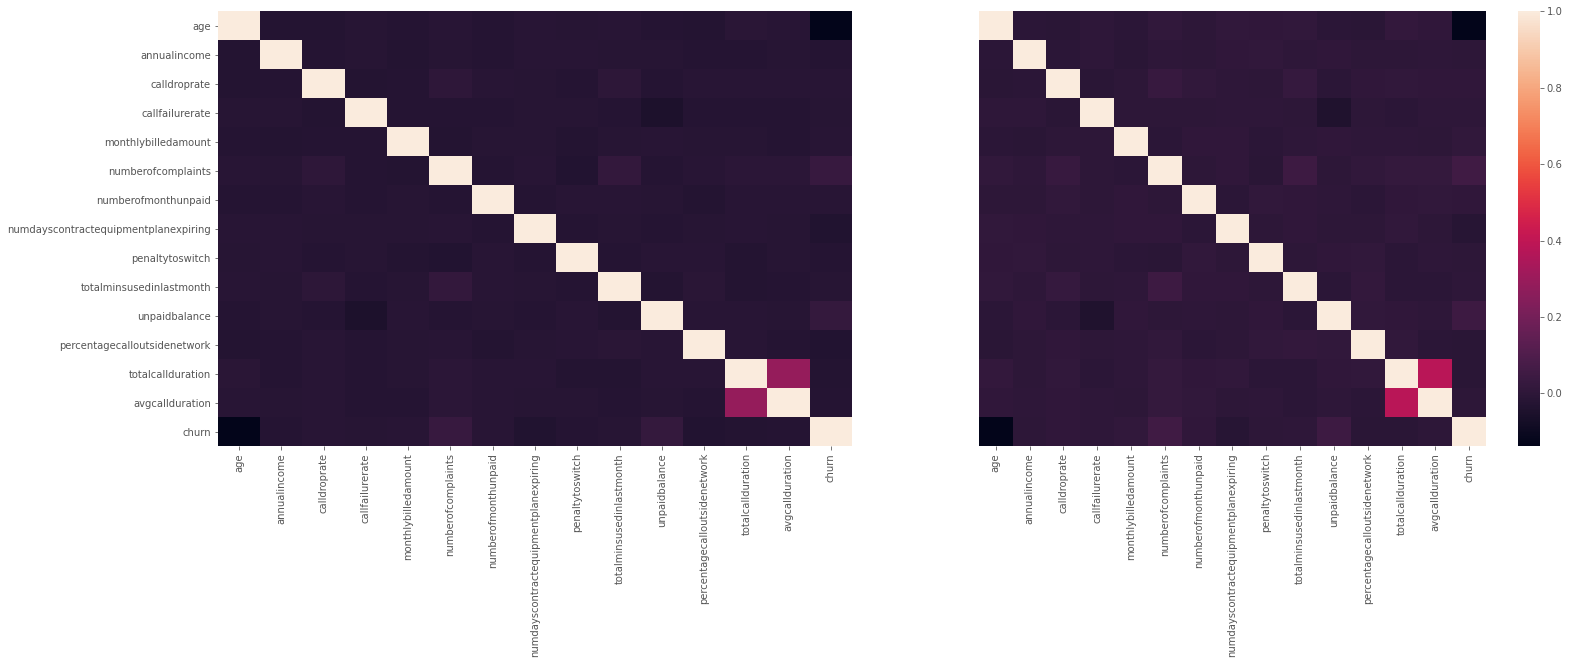

In [575]:
fig, axes = plt.subplots(1, 2, figsize=(25, 8))
sns.heatmap(df[num_features+['churn']].corr(method='kendall'), cbar=False, ax=axes[0]);
sns.heatmap(df[num_features+['churn']].corr(), yticklabels=False, ax=axes[1]);

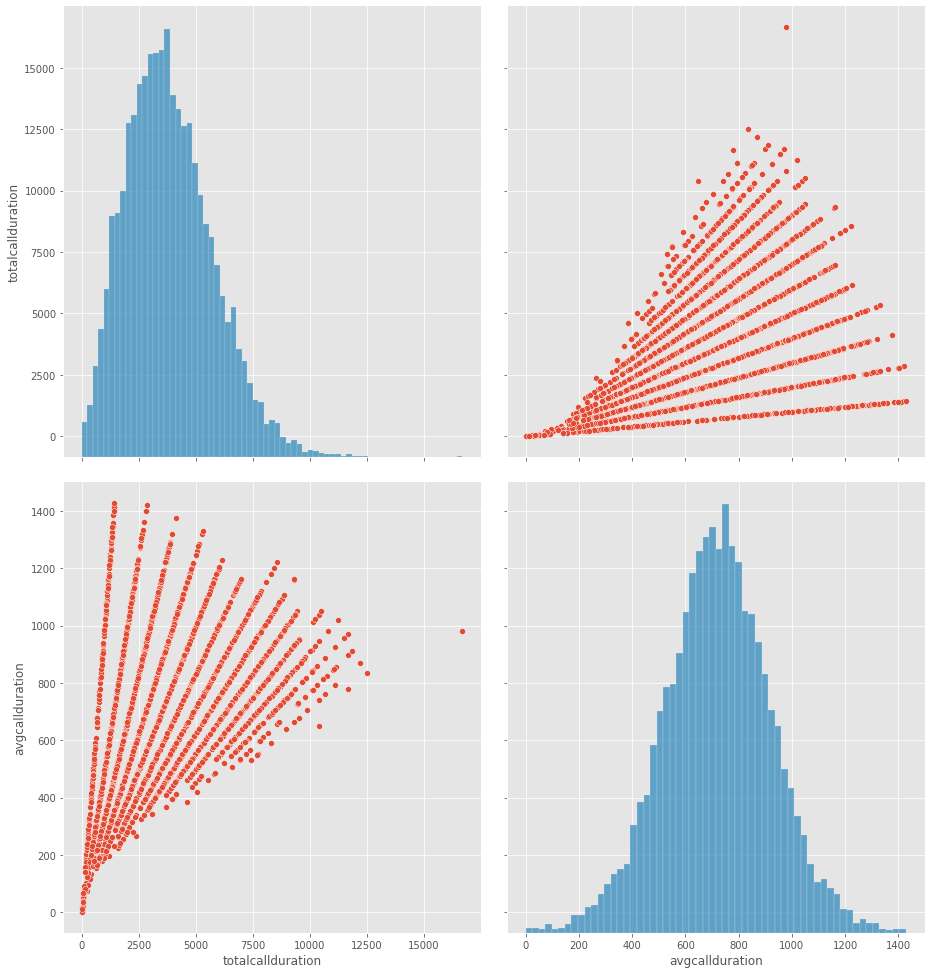

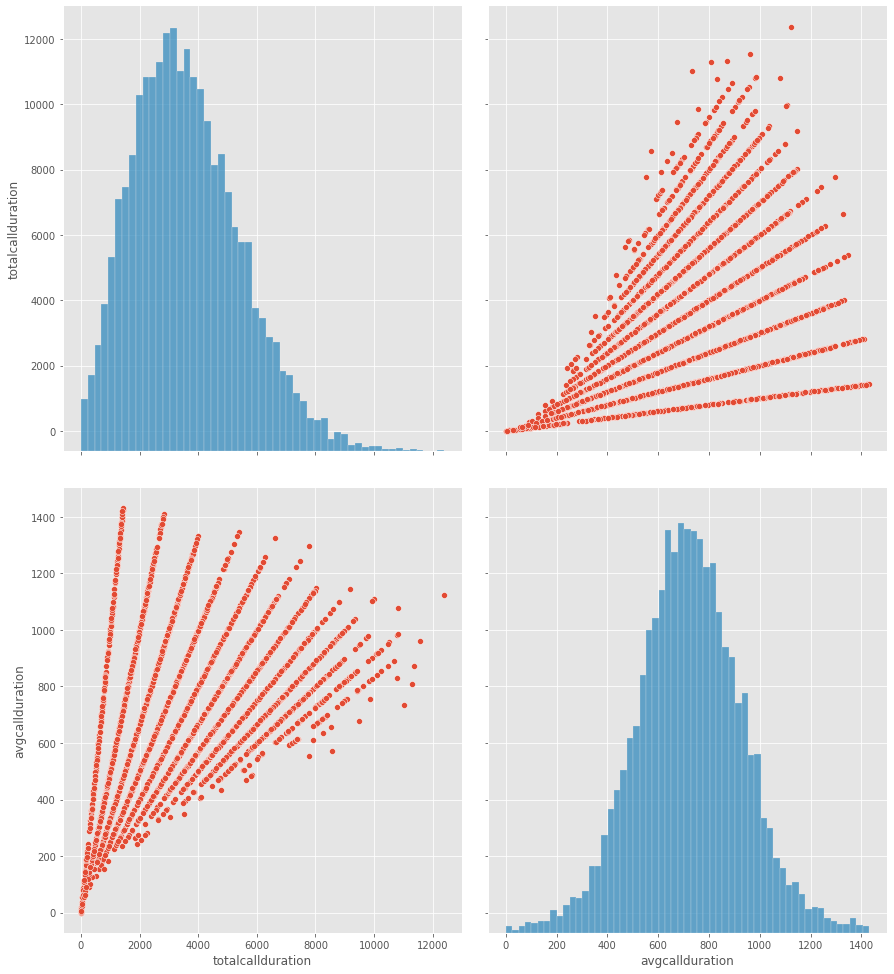

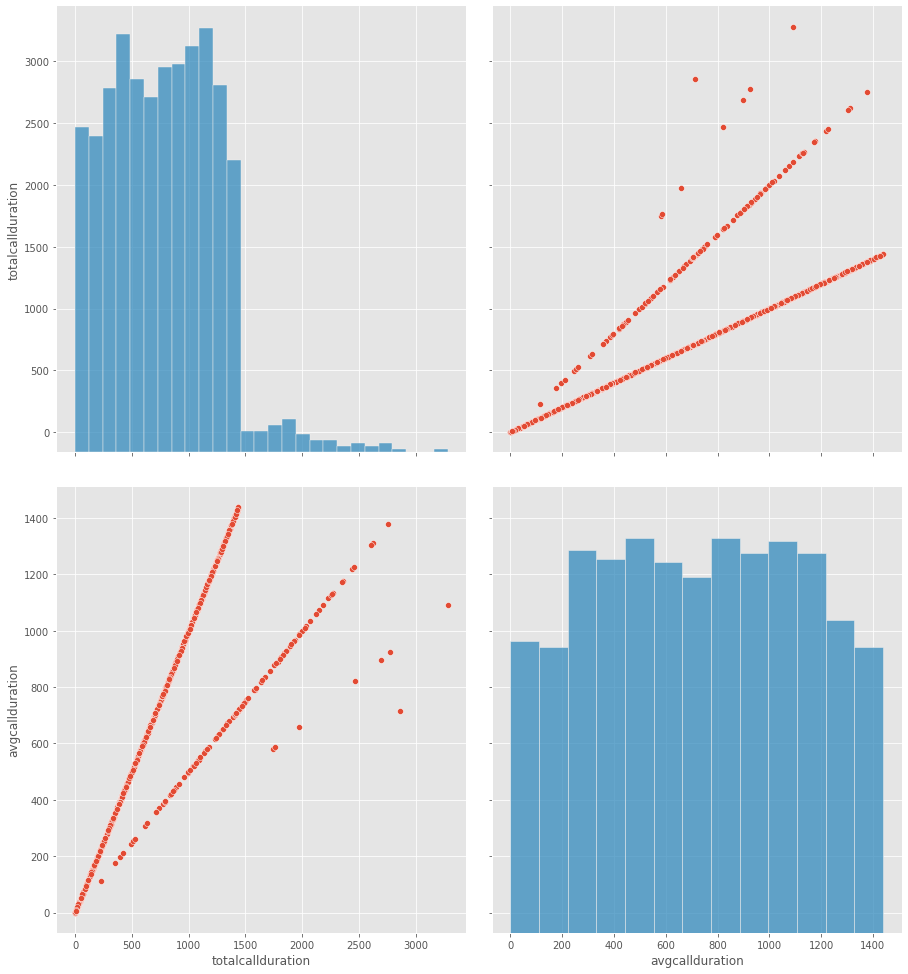

In [350]:
# Линейно-зависимые переменные помесячно

for i in df.month.unique():
    sns.pairplot(df.loc[df.month == i, ['totalcallduration', 'avgcallduration']]).fig.set_size_inches(15,15);

## Графики по фичам

In [722]:
unique_customers_df = df.copy()
unique_customers_df = unique_customers_df.drop_duplicates(subset='customerid')

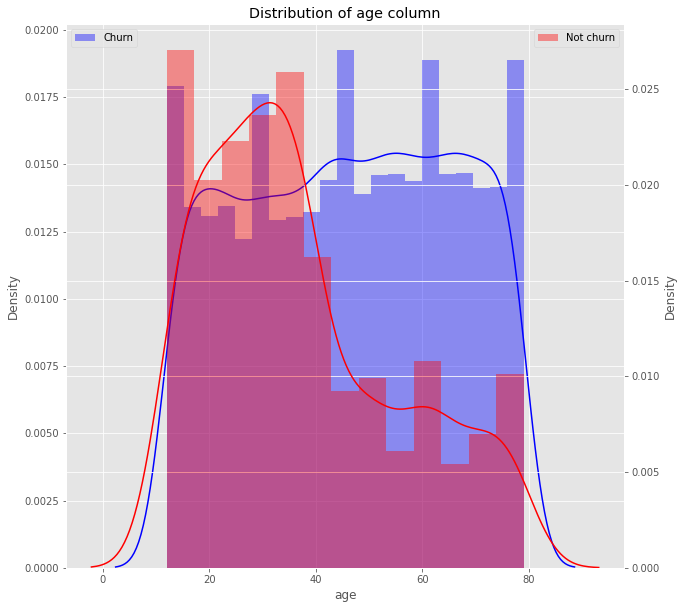

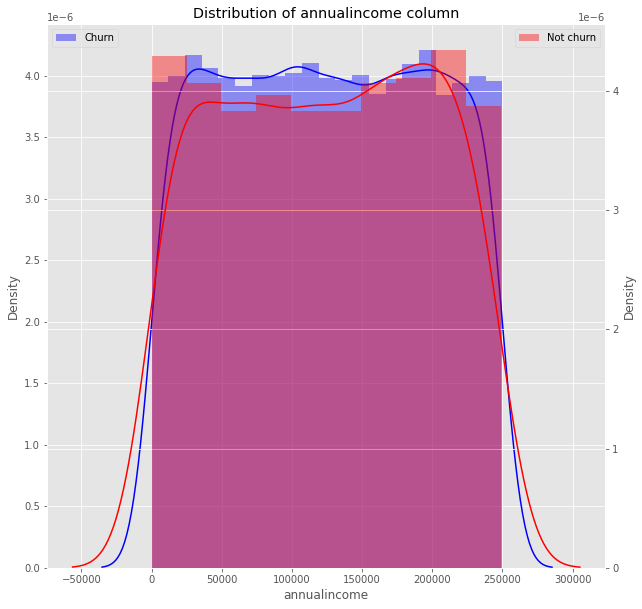

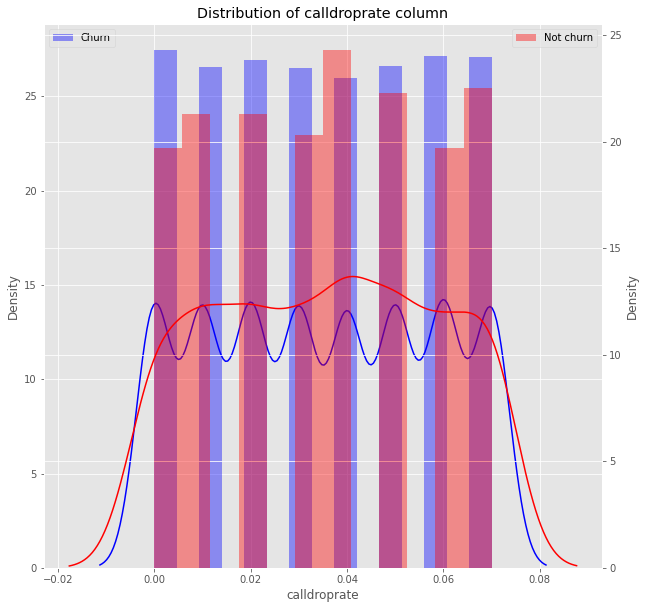

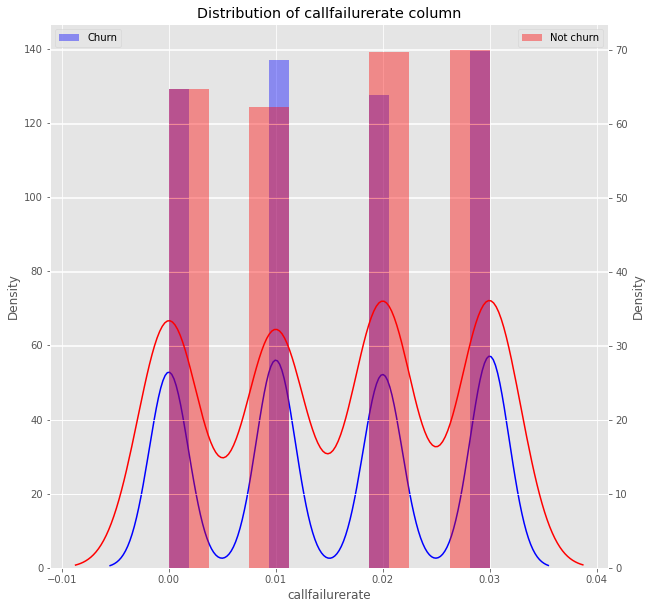

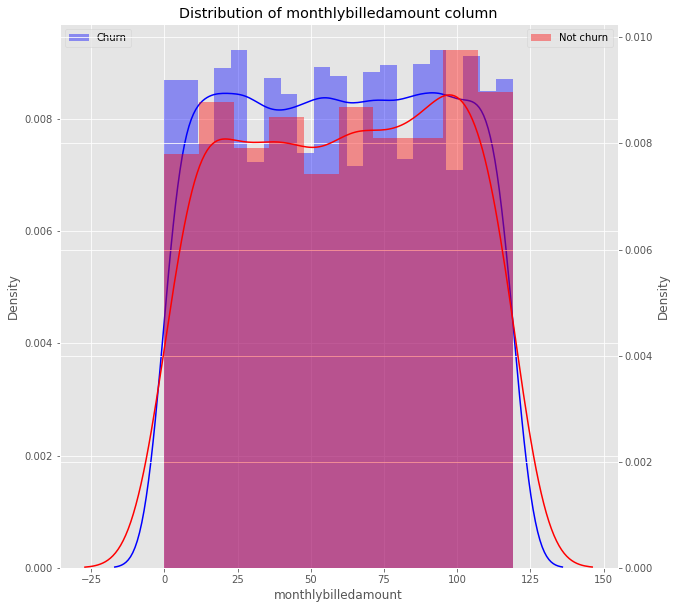

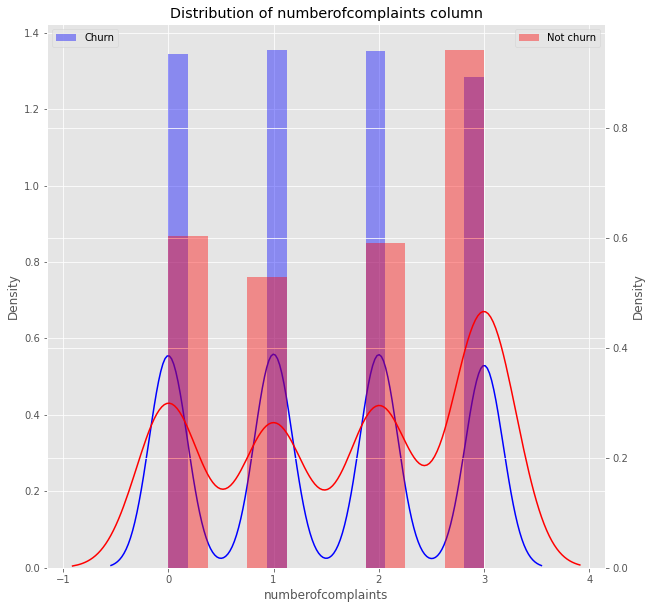

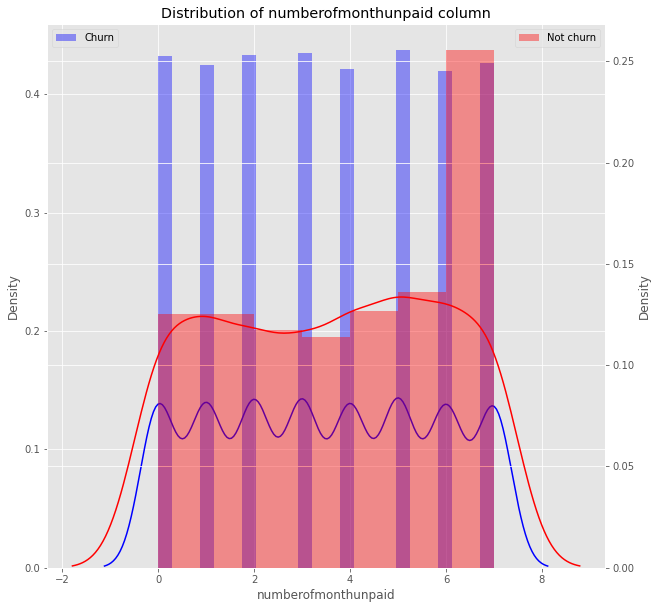

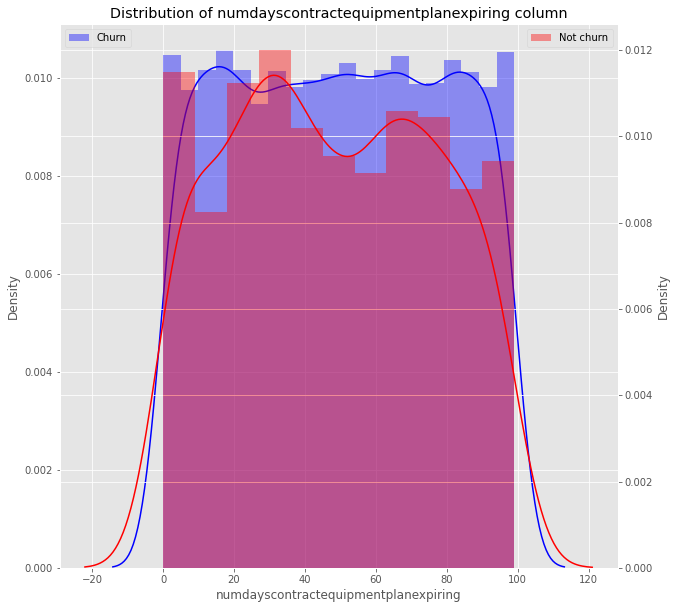

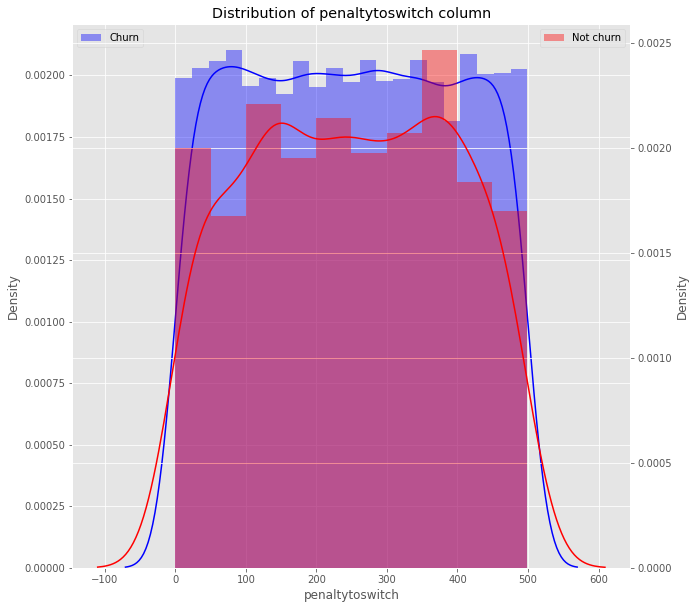

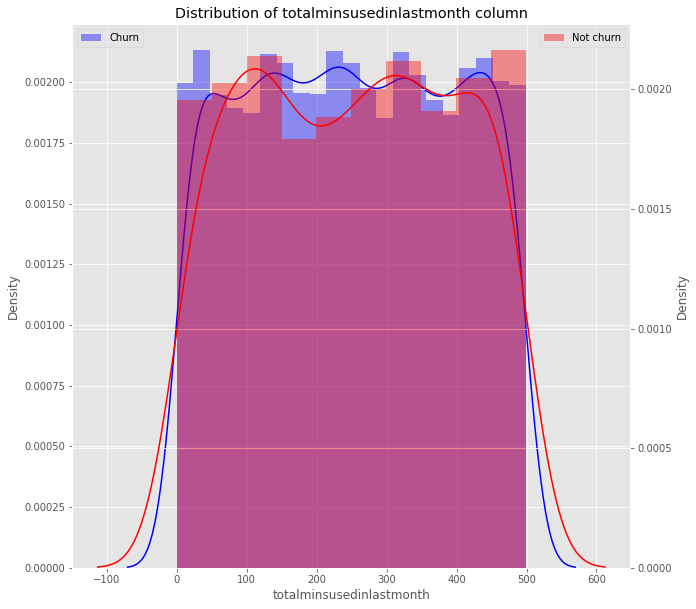

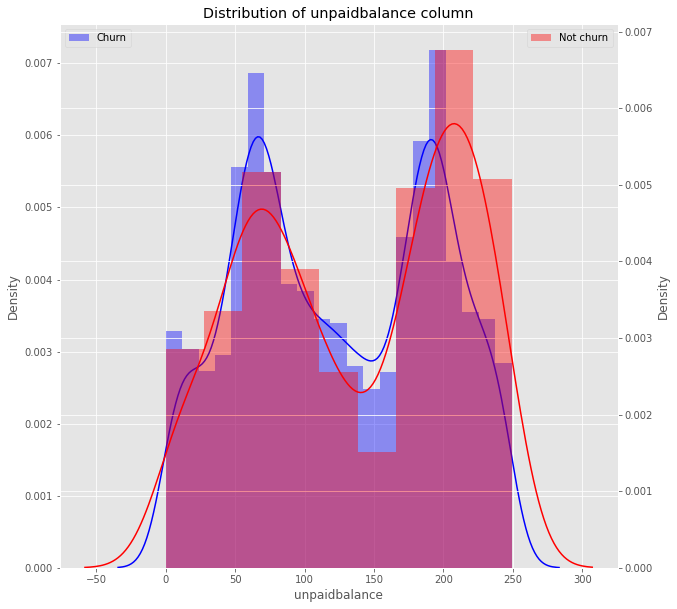

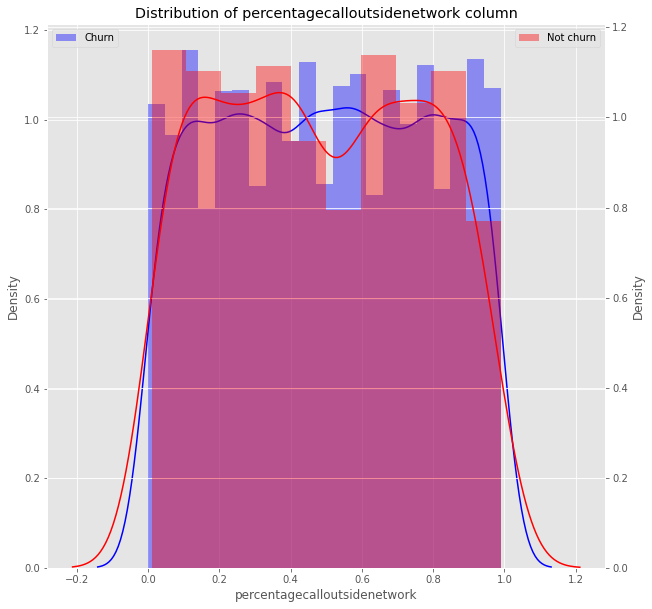

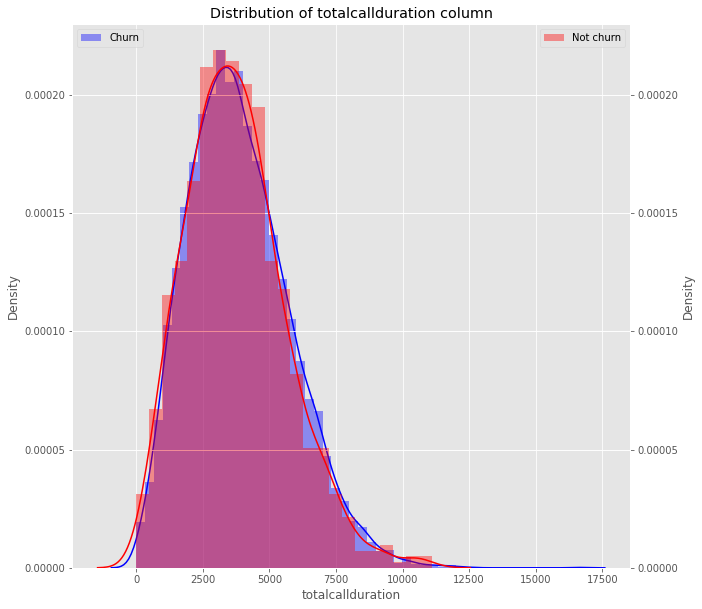

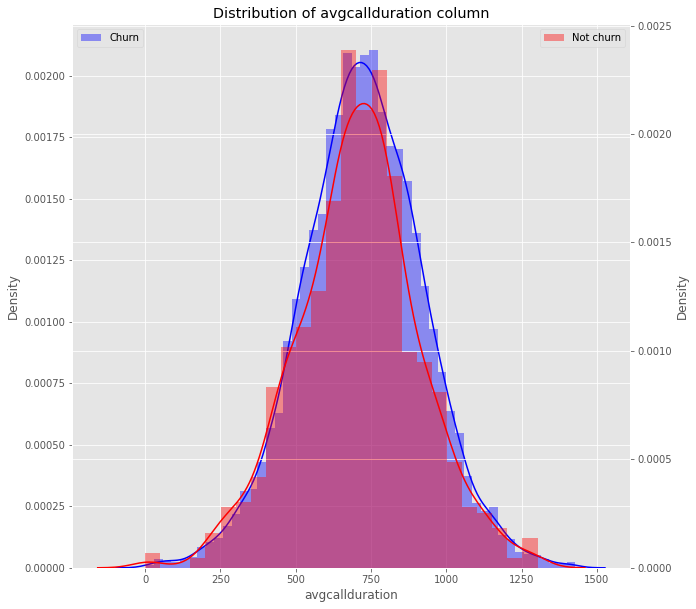

In [723]:
for i, c in enumerate(num_features):
    plt.figure(figsize=(10, 10))
    ax = sns.distplot(unique_customers_df.loc[df.churn == 0, c], label='Churn', kde=True, color='b', norm_hist=True);
    ax2 = ax.twinx()
    sns.distplot(unique_customers_df.loc[df.churn == 1, c], label='Not churn', kde=True, norm_hist=True, color='r', ax=ax2);
    plt.title(f'Distribution of { c } column')
    ax.legend(loc='upper left')
    ax2.legend(loc='upper right')

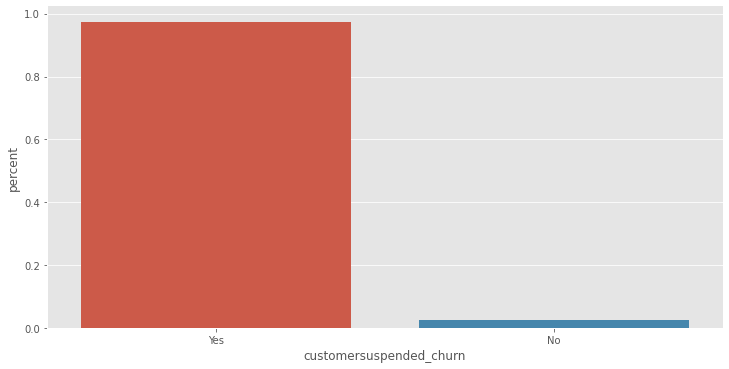

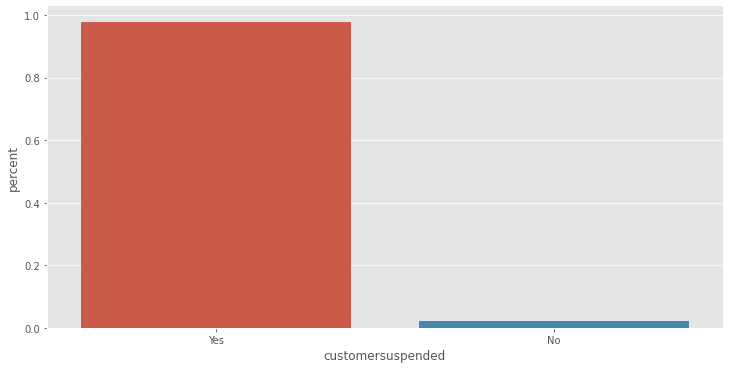

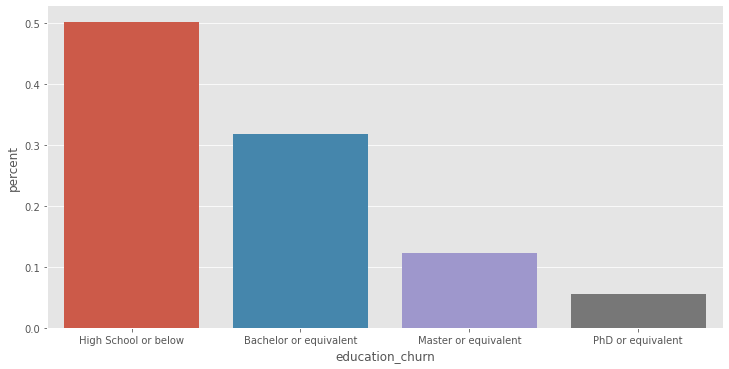

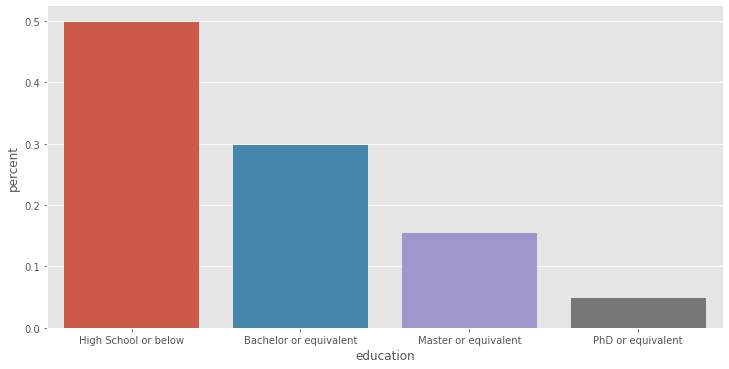

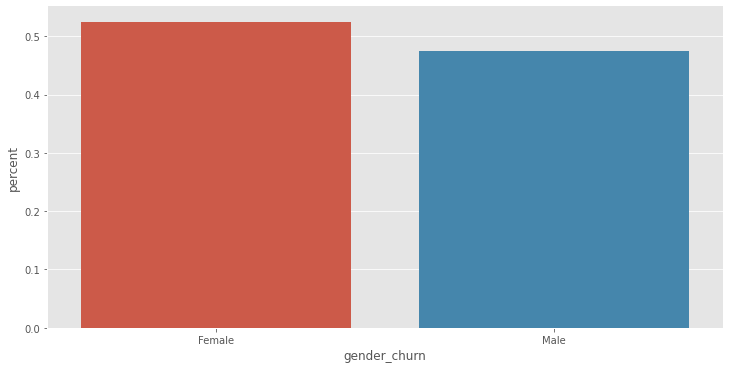

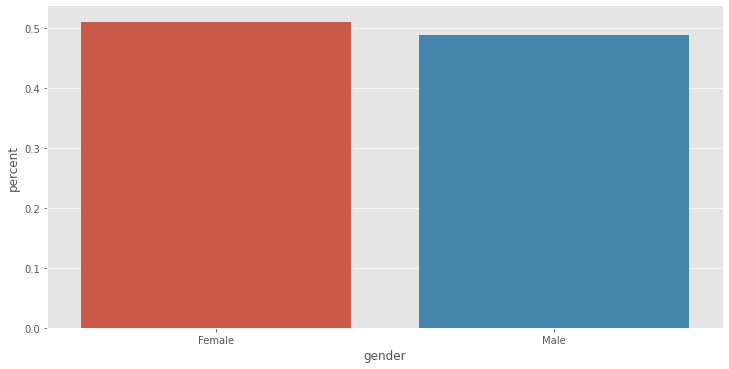

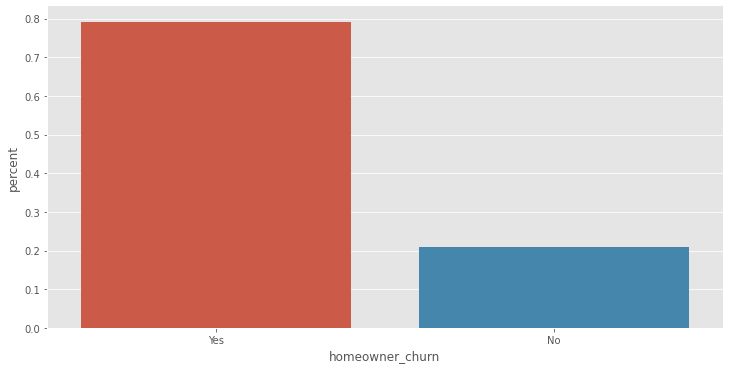

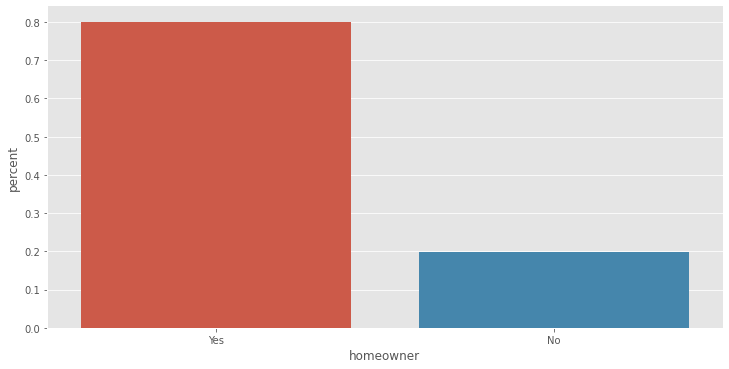

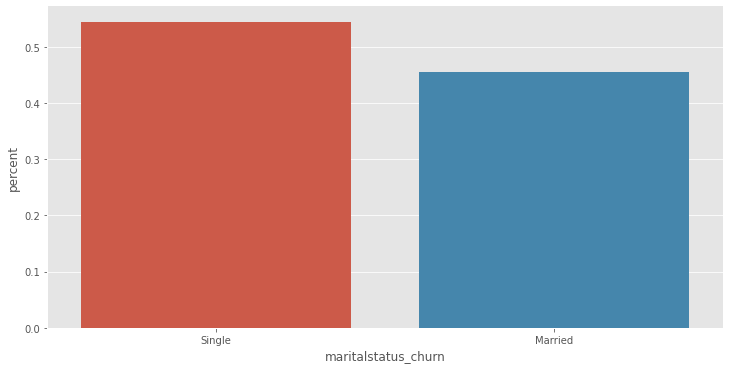

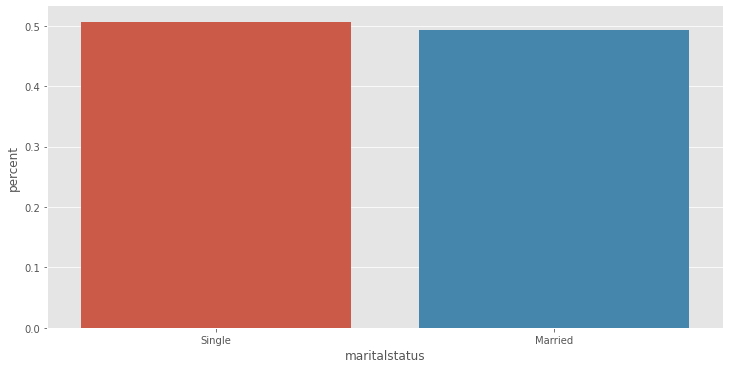

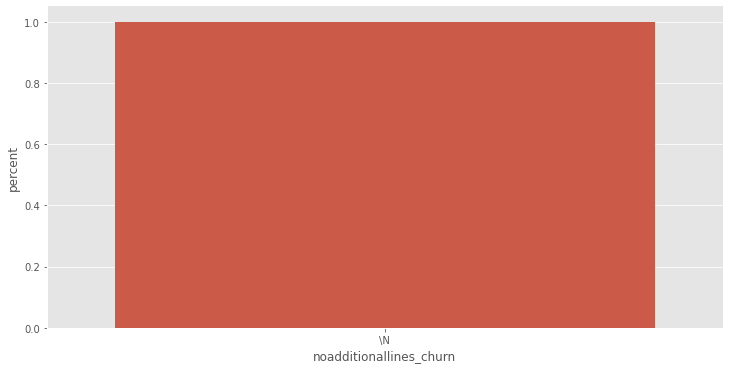

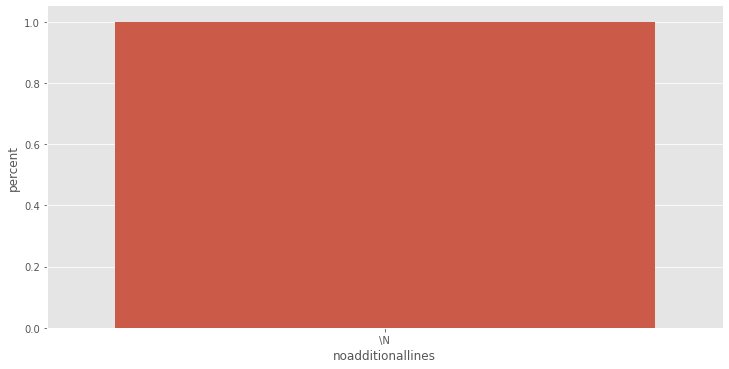

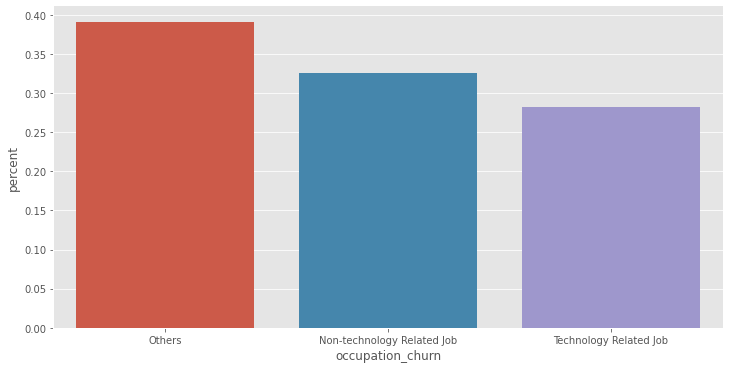

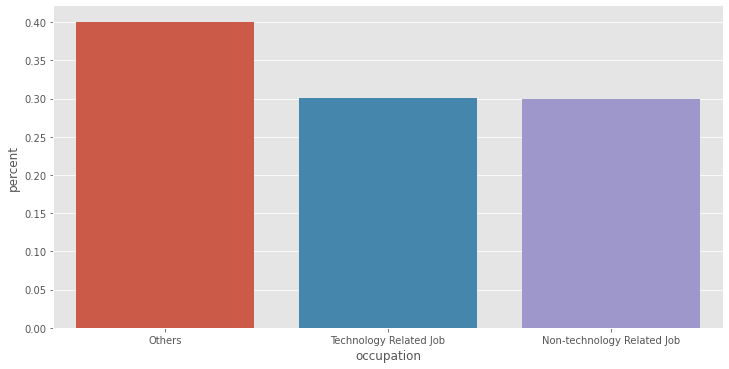

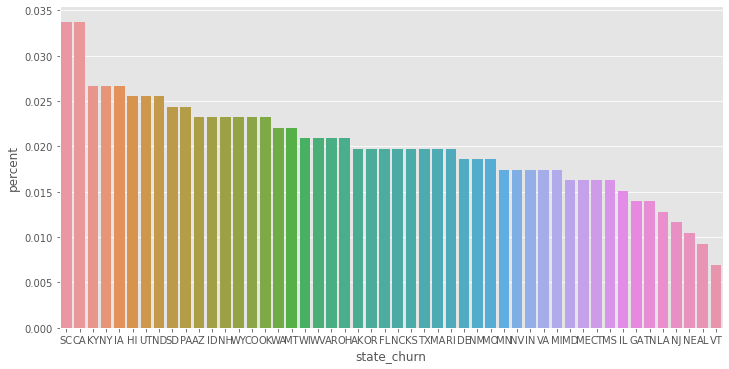

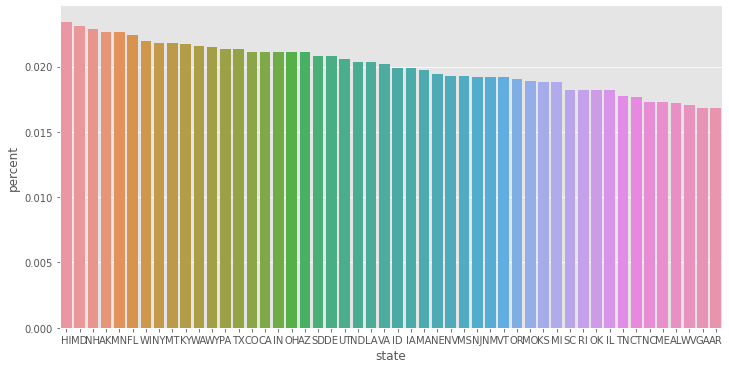

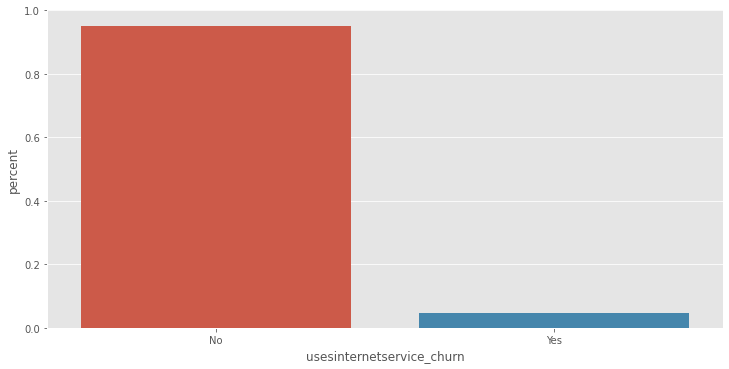

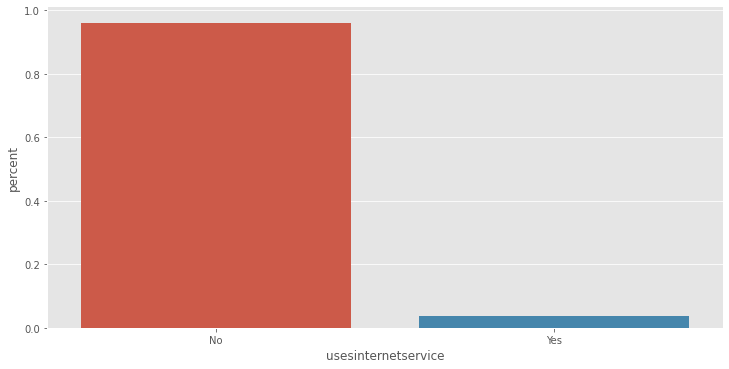

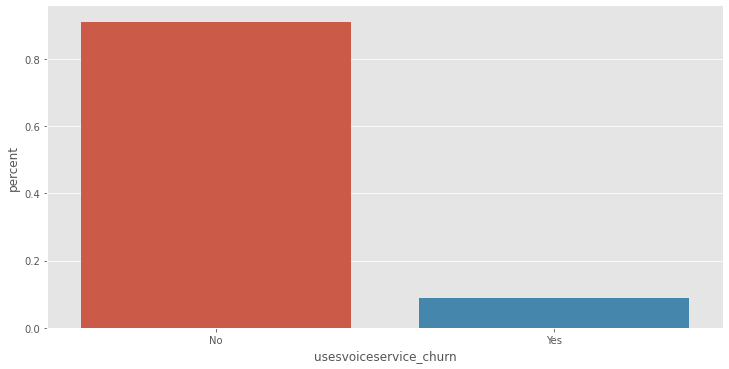

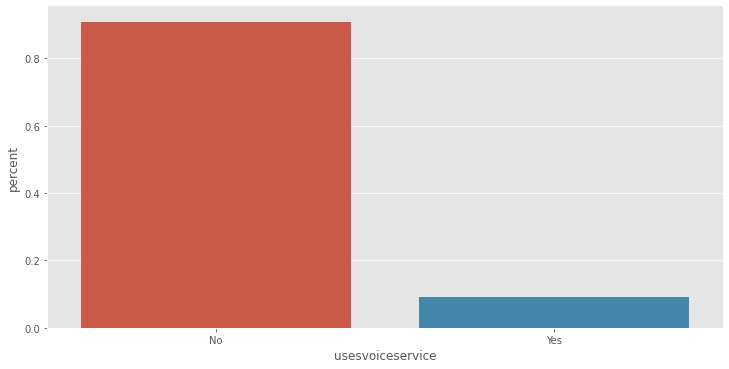

In [756]:
# Cходу не придумал, как лучше показать доли категорий по фичам

for c in cat_features:
    c_1 = unique_customers_df.loc[unique_customers_df.churn == 1, c].value_counts(normalize=True).reset_index()
    c_1.columns = [c+'_churn', 'percent']
    
    c_0 = unique_customers_df.loc[unique_customers_df.churn == 0, c].value_counts(normalize=True).reset_index()
    c_0.columns = [c, 'percent']
    
    sns.catplot(
        x=c+'_churn',
        y='percent',
        kind='bar',
        data=c_1,
        height=5,
        aspect=2
    );
    
    sns.catplot(
        x=c,
        y='percent',
        kind='bar',
        data=c_0,
        height=5,
        aspect=2
    );

Text(0.5, 1.0, 'Distribution of usesvoiceservice col (NOT CHURN)')

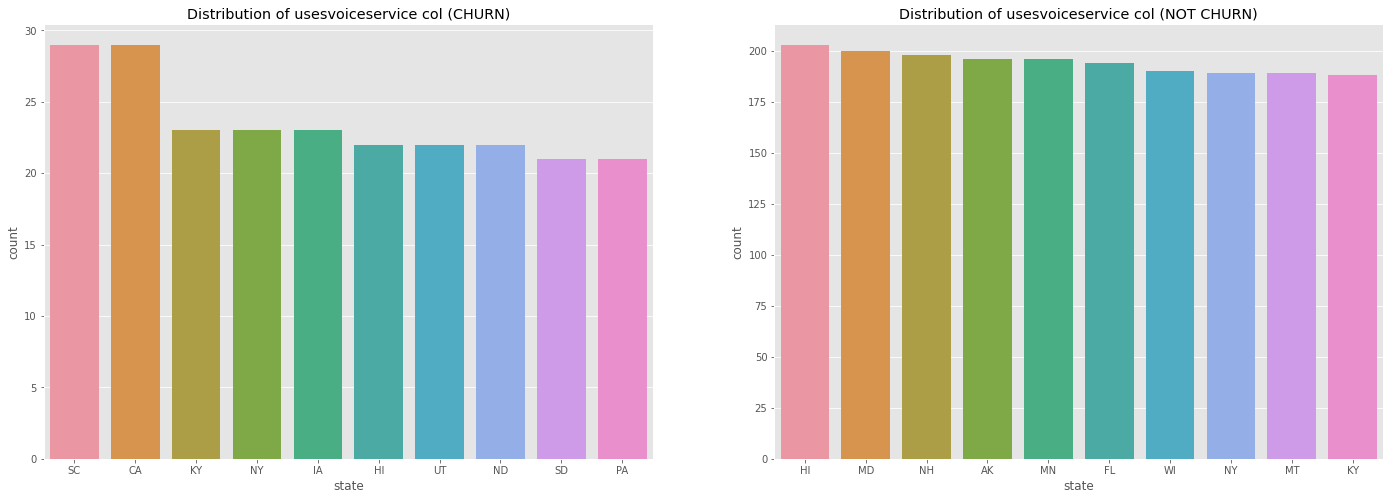

In [757]:
# Рассмотрим топ 10 штатов по оттоку
# Списки отличаются полностью, причем в отточной группе есть 2 лидера

fig, axes = plt.subplots(1, 2, figsize=(24, 8))
sns.countplot(
    unique_customers_df.loc[unique_customers_df.churn == 1, 'state'], 
    ax=axes[0], 
    order=unique_customers_df.loc[unique_customers_df.churn == 1, 'state'].value_counts().iloc[:10].index
);
sns.countplot(
    unique_customers_df.loc[unique_customers_df.churn == 0, 'state'], 
    ax=axes[1], 
    order=unique_customers_df.loc[unique_customers_df.churn == 0, 'state'].value_counts().iloc[:10].index
);
axes[0].set_title(f'Distribution of {c} col (CHURN)')
axes[1].set_title(f'Distribution of {c} col (NOT CHURN)')

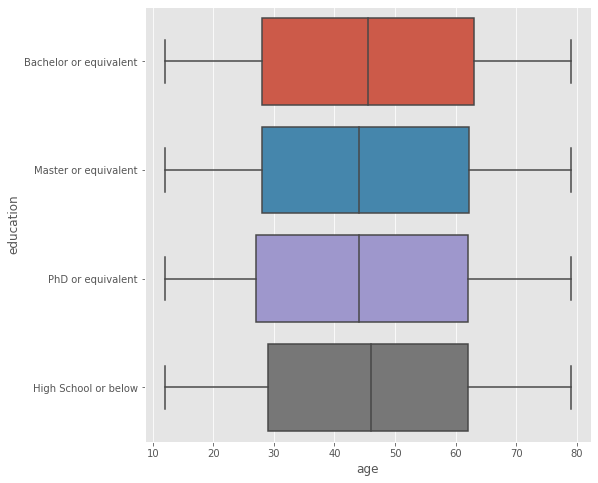

In [758]:
# Рассмторим распределение возраста от образования
# Предполагал, что медиана будем смещаться вправо по мере роста образования (школа и ниже -> доктор)
# Такое распределение, скорее всего, связано с шумом

plt.figure(figsize=(8, 8))
sns.boxplot(data=unique_customers_df, x='age', y='education', orient='h');

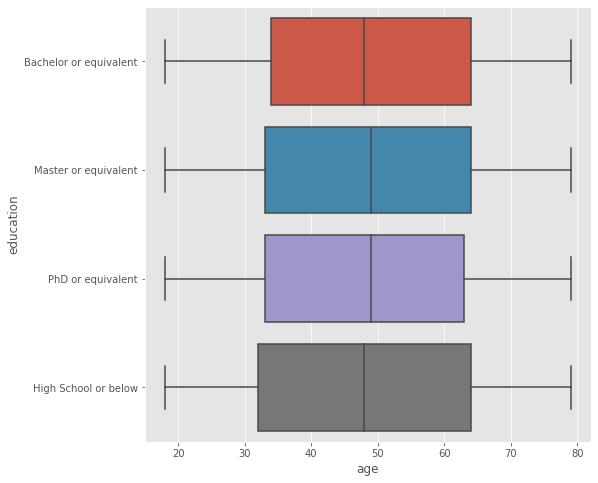

In [761]:
# Попробуем отфильровать только пользователей старше 18 лет
# Такое распределение кажется более логичным

plt.figure(figsize=(8,8))
sns.boxplot(data=unique_customers_df[unique_customers_df.age >= 18], x='age', y='education', orient='h');

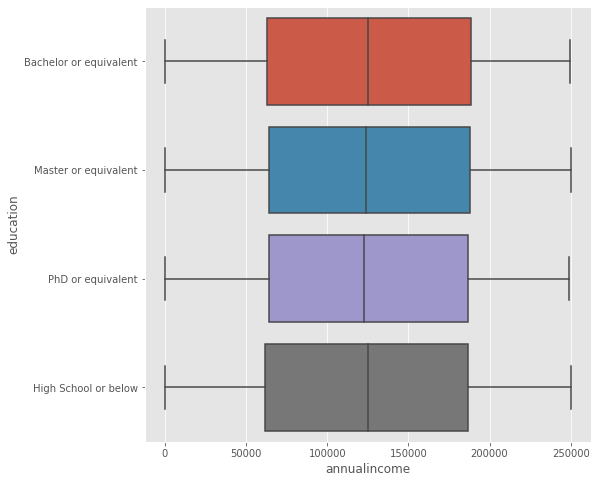

In [765]:
# Кажется, что доход не зависит от уровня образования

plt.figure(figsize=(8,8))
sns.boxplot(data=unique_customers_df[unique_customers_df.age >= 18], x='annualincome', y='education', orient='h');

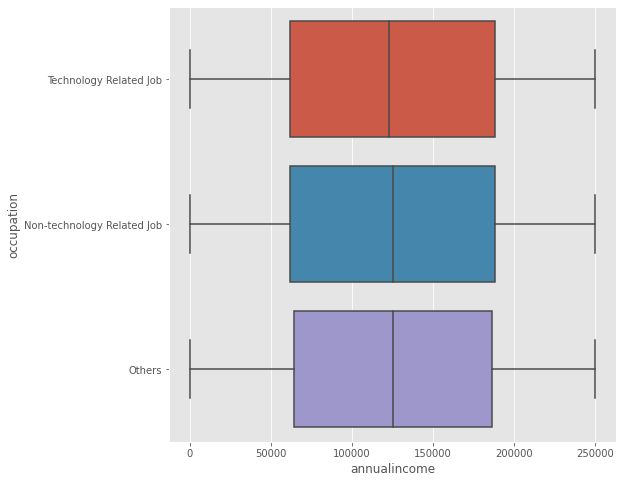

In [766]:
# От сферы деятельности доход так же зависит слабо

plt.figure(figsize=(8,8))
sns.boxplot(data=unique_customers_df[unique_customers_df.age >= 18], x='annualincome', y='occupation', orient='h');

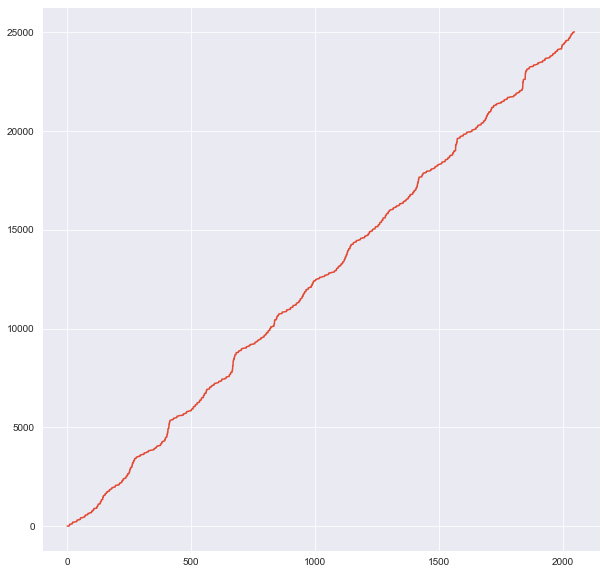

In [892]:
plt.figure(figsize=(10,10))
plt.plot(df.loc[df.annualincome <= df.annualincome.quantile(.1), 'annualincome'].sort_values().reset_index(drop=True));

# Feature engineering ideas 

# Baseline model 

## Данные для baseline'а

In [924]:
df_upd = df.copy()
df_upd.drop_duplicates(subset=['customerid'], inplace=True)

exclude_fs = ['customerid', 'churn', 'year', 'month', 'callingnum']

cat_fs = df_upd.select_dtypes(include=["bool", "object"]).columns.tolist()
num_fs = [col for col in df_upd.select_dtypes(include=["int64", "float64"]).columns.tolist() if col not in exclude_fs]

In [932]:
def all_combinations(any_list):
    return itertools.chain.from_iterable(
        itertools.combinations(any_list, i + 1)
        for i in range(len(any_list)))


for col in cat_fs:
    df_upd[col] = df_upd[col].astype(str)
    
comb = [list(l) for l in all_combinations(cat_fs) if len(l)<=2 and  len(l)>1]

for col in comb:
    new_col = '_'.join(col)
    df_upd[f'{ new_col }'] = df_upd[comb[-1]].apply(lambda x:'_'.join(x), axis=1)

In [933]:
df_upd.shape

(9525, 74)

In [934]:
exclude_fs = ['customerid', 'churn', 'year', 'month', 'callingnum']

cat_features = list(set(df_upd.select_dtypes(include=["bool", "object"]).columns.tolist()))
num_features = [col for col in df_upd.select_dtypes(include=["int64", "float64"]).columns.tolist() if col not in exclude_fs]

len(cat_features), len(num_features)

(55, 14)

## Параметры и инициализации

In [935]:
params = {
    'params_clf': {
        'solver': 'liblinear',
        'penalty': 'l1',
        'C': 1,
        'class_weight': {
            1: df_upd.shape[0]/(2 * df_upd.loc[df_upd.churn == 1, 'churn'].shape[0]),
            0: df_upd.shape[0]/(2 * df_upd.loc[df.churn == 0, 'churn'].shape[0])
        },
        'n_jobs': 4,
        'random_state': 42
    },
    'params_skf': {
        'n_splits': 5,
        'shuffle': True,
        'random_state': 42
    }
}

skf = StratifiedKFold(**params['params_skf'])

# Используем ЛогРег в качестве бейзлайна
clf_baseline = LR(**params['params_clf'])

## Функции для обучения и отрисовки графиков

In [936]:
def plt_roc_auc_curve(y_test, y_probs, y_train, y_train_probs):    
    auc_score = roc_auc_score(y_test, y_probs)
    fpr, tpr, _ = roc_curve(y_test, y_probs)
    
    auc_score1 = roc_auc_score(y_train, y_train_probs)
    fpr1, tpr1, _ = roc_curve(y_train, y_train_probs)
    
    plt.figure(figsize=(8, 8))
    plt.plot([0,1], [0,1], linestyle='--', label='Random model')
    plt.plot(fpr, tpr, label='Test AUC-ROC curve', color='r');
    plt.plot(fpr1, tpr1, label='Train AUC-ROC curve', color='b');
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    props = {
            'boxstyle': 'round', 
            'facecolor': 'wheat', 
            'alpha': 0.5
            }
    
    plt.text(0.05, 0.95, f'Test AUC-ROC score: { auc_score.round(3) }\nTrain AUC-ROC score: { auc_score1.round(3) }', fontsize=12,
            verticalalignment='top', bbox=props)

In [937]:
def preproc_train_bl(X, y, num_features_list, cat_features_list):
    '''
    Препроцессинг трейна
    
    :param pd.DataFrame X: ...
    
    :return: ...
    '''
#     В качестве кодировщика кат фичей используем target encoder,
    t_encoder = TargetEncoder(return_df=True)
    t_encoder_fitted = t_encoder.fit(X[cat_features_list], y)
    encoded_cat_features = t_encoder_fitted.transform(X[cat_features_list]).reset_index(drop=True)
    scaled_features_c = pd.DataFrame(
                                    scale(encoded_cat_features),
                                    columns=cat_features_list
                            )
    
    scaled_features_n = pd.DataFrame(
    scale(X[[c for c in num_features_list if c not in ['year', 'month']]]),
    columns=[c for c in num_features_list if c not in ['year', 'month']]
                            )
    
    X_p = pd.concat([scaled_features_c, scaled_features_n], axis=1, ignore_index=True)
    X_p.columns = cat_features_list + num_features_list
    
    return_dict = {
        'X': X_p,
        'y': y,
        'cat_encoder': t_encoder_fitted
                  }
    
    return return_dict


def preproc_test_bl(X, num_features_list, cat_features_list, cat_encoder):
    '''
    Препроцессинг теста
    
    :param pd.DataFrame X: ...
    
    :return: ...
    '''
    encoded_cat_features = cat_encoder.transform(X[cat_features_list]).reset_index(drop=True)
    scaled_features_c = pd.DataFrame(
                                    scale(encoded_cat_features),
                                    columns=cat_features_list
                            )
    
    scaled_features_n = pd.DataFrame(
        scale(X[[c for c in num_features_list if c not in ['year', 'month']]]),
        columns=[c for c in num_features_list if c not in ['year', 'month']]
                                )
    X_p = pd.concat([scaled_features_c, scaled_features_n], axis=1, ignore_index=True)
    X_p.columns = cat_features_list + num_features_list
    
    return X_p

## Обучение и проверки

In [938]:
# Т.к. берем просто уникальных клиентов, можем разделить выборку с помощью train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df_upd, 
    df_upd.churn,
    stratify=df_upd.churn,
    test_size=0.3,
    shuffle=True,
    random_state=42
    )

train_data = preproc_train_bl(X_train, y_train, num_features, cat_features)

clf_baseline_fitted = clf_baseline.fit(train_data['X'], train_data['y'])

In [939]:
y_test.value_counts(normalize=True), y_train.value_counts(normalize=True)

(0    0.909727
 1    0.090273
 Name: churn, dtype: float64,
 0    0.909555
 1    0.090445
 Name: churn, dtype: float64)

In [940]:
# Кросс-валидация

roc_auc_cv = cross_val_score(
    clf_baseline,
    train_data['X'],
    train_data['y'],
    scoring='roc_auc',
    cv=skf,
    n_jobs=4
)

roc_auc_cv

array([0.67710682, 0.68166488, 0.67704727, 0.64115829, 0.68785288])

In [941]:
roc_auc_cv.mean(), roc_auc_cv.std()

(0.6729660271730539, 0.016387943993702022)

In [942]:
test_data = preproc_test_bl(X_test, num_features, cat_features, train_data['cat_encoder'])

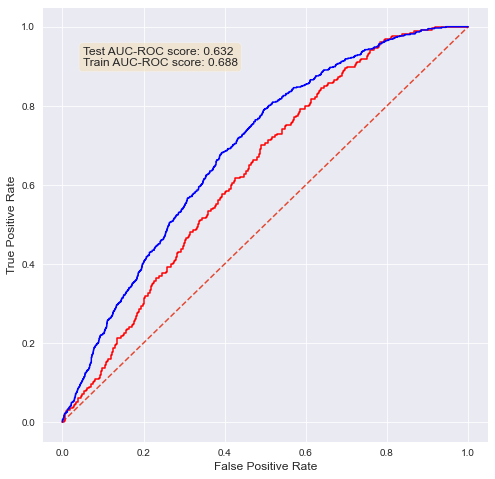

In [946]:
plt_roc_auc_curve(
    y_test, 
    clf_baseline_fitted.predict_proba(test_data)[:, 1],
    y_train,
    clf_baseline_fitted.predict_proba(train_data['X'])[:, 1],
)

**TODO: написать модуль для "честной" кросс валидации**

In [886]:
bc = functions.BinaryClassification(
                                    y_test,
                                    clf_baseline_fitted.predict_proba(test_data)[:, 1],
                                    labels=[0,1],
                                    threshold=.4
                            )

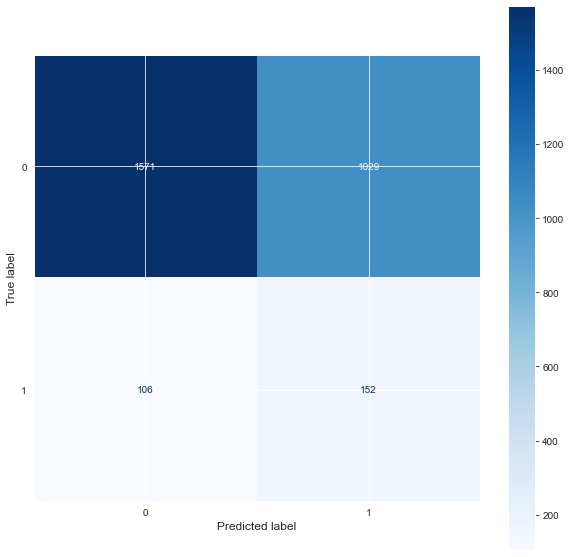

In [889]:
fig, ax = plt.subplots(
    figsize=(10, 10),
)

plot_confusion_matrix(
    clf_baseline_fitted,
    test_data,
    y_test,
    cmap='Blues',
    ax=ax
);

In [888]:
print(metrics.classification_report(
    y_test,
    clf_baseline_fitted.predict_proba(test_data)[:, 1].round(0)
))

              precision    recall  f1-score   support

           0       0.94      0.60      0.73      2600
           1       0.13      0.59      0.21       258

    accuracy                           0.60      2858
   macro avg       0.53      0.60      0.47      2858
weighted avg       0.86      0.60      0.69      2858



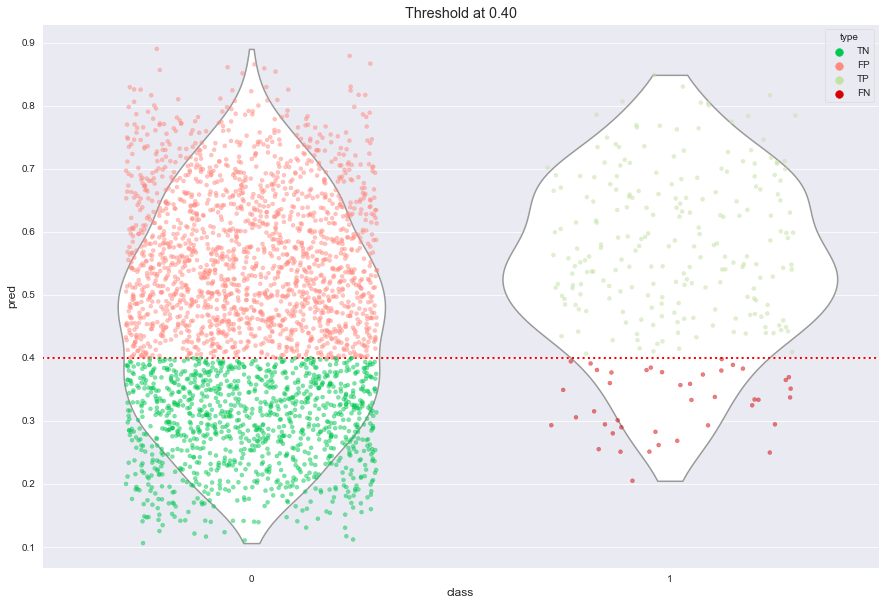

In [797]:
# Немного сдвинем отсечку по бинаризации

plt.figure(figsize=(15, 10));
bc_class_dit = bc.plot_class_distribution()

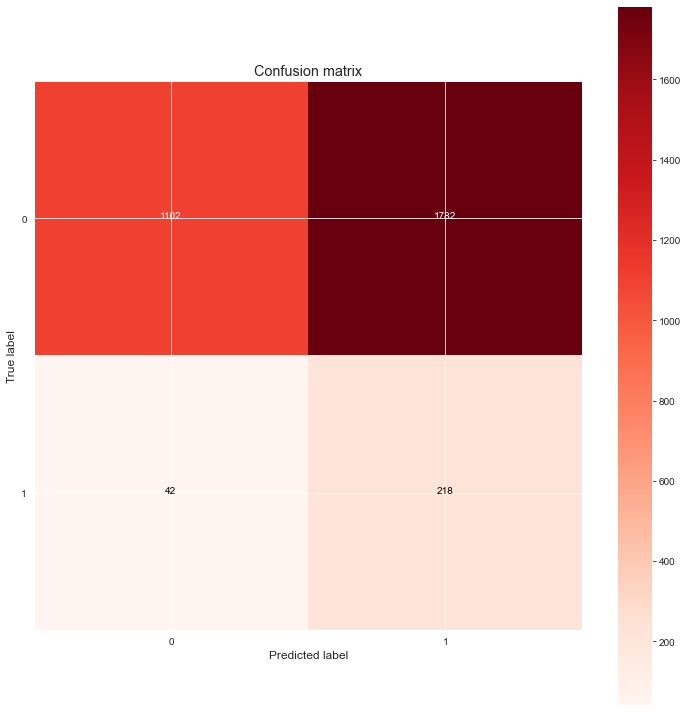

In [798]:
plt.figure(figsize=(10,10))
bc_conf_m = bc.plot_confusion_matrix(label_rotation=0)

In [890]:
threshold = .4
print(metrics.classification_report(
    y_test,
    np.where(clf_baseline_fitted.predict_proba(test_data)[:, 1] > threshold, 1, 0)
))

              precision    recall  f1-score   support

           0       0.95      0.40      0.57      2600
           1       0.12      0.79      0.20       258

    accuracy                           0.44      2858
   macro avg       0.53      0.59      0.38      2858
weighted avg       0.87      0.44      0.53      2858



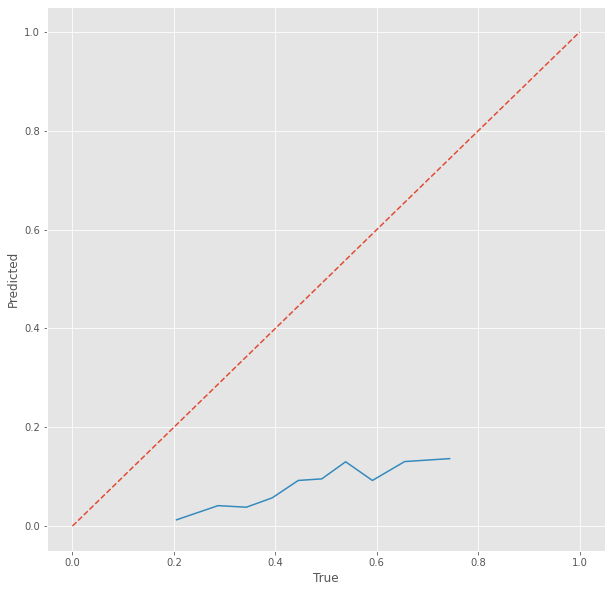

In [772]:
# Проверим, насколько модель уверена в своих предсказаниях. Для этого построим calibration_curve

y_means, proba_means = calibration_curve(
    y_test,
    clf_baseline_fitted.predict_proba(test_data)[:, 1],
    n_bins=10, 
    strategy='quantile')

plt.figure(figsize=(10,10))
plt.plot([0,1], [0,1], linestyle='--', label='Perfect calibration')
plt.plot(proba_means, y_means);
plt.xlabel('True');
plt.ylabel('Predicted');

In [944]:
f_coefs = pd.DataFrame({
                        'col_name': cat_features+num_features, 
                        'col_coef': abs(clf_baseline_fitted.coef_[0])
                    }).sort_values(by='col_coef', ascending=False)

f_coefs[f_coefs.col_coef > 0]

,col_name,col_coef
55,age,0.553456
31,state,0.288236
65,unpaidbalance,0.268795
60,numberofcomplaints,0.247838
45,education,0.095903
66,percentagecalloutsidenetwork,0.077438
67,totalcallduration,0.075850
46,usesvoiceservice,0.060190
58,callfailurerate,0.059275
62,numdayscontractequipmentplanexpiring,0.056645


In [917]:
notzero_features = f_coefs.loc[f_coefs.col_coef > 0, 'col_name'].values

## Попробуем обучиться на ненулевых фичах

In [920]:
clf_baseline_s = LR(**params['params_clf'])
clf_baseline_fitted_s = clf_baseline_s.fit(train_data['X'][notzero_features], train_data['y'])

In [921]:
# Кросс-валидация
roc_auc_cv = cross_val_score(
    clf_baseline_s,
    train_data['X'][notzero_features],
    train_data['y'],
    scoring='roc_auc',
    cv=skf,
    n_jobs=4
)

roc_auc_cv

array([0.68646141, 0.69892283, 0.67141385, 0.63923468, 0.68609361])

In [922]:
roc_auc_cv.mean(), roc_auc_cv.std()

(0.676425274394336, 0.020535798936718346)

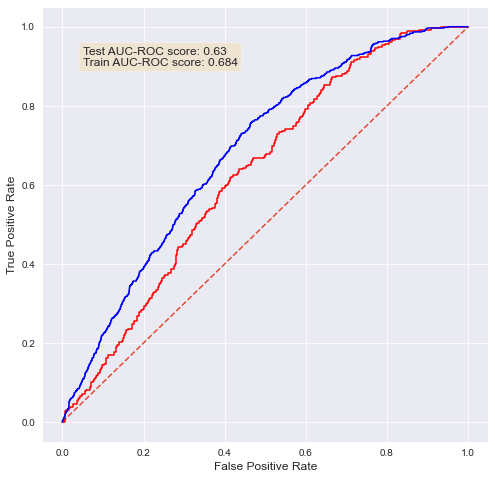

In [923]:
plt_roc_auc_curve(
    y_test, 
    clf_baseline_fitted_s.predict_proba(test_data[notzero_features])[:, 1],
    y_train,
    clf_baseline_fitted_s.predict_proba(train_data['X'][notzero_features])[:, 1],
)

# Выводы

- непонятна технология сбора и смысл таргета, что крайне важно
- такой подход к формированию обучающей выборки, скорее всего не подходит, так как в проде мы хотим предсказывать отток на следующий месяц, то есть правильнее будет обучаться на 1 месяце, затем предсказывать 2 и тд, но это повлечет за собой последствия из-за того, что во втором месяце будут практически идентичные объекты из 1 месяца

**Что еще можно попробовать:**
- SMOTE (интересно, но бесполезно для модели в проде)
- нагенерить фичи из катфичей (их сочетания)
- поискать выбросы (что для данной выборки кажется бесполезным)